🚀 Entraînement des modèles...
✅ Entraînement terminé !

📊 Résultats sur le dataset de test :
Voting Type  Accuracy  Precision  Recall  F1-score
Hard Voting     0.846      0.773   0.979     0.864
Soft Voting     0.852      0.781   0.977     0.868



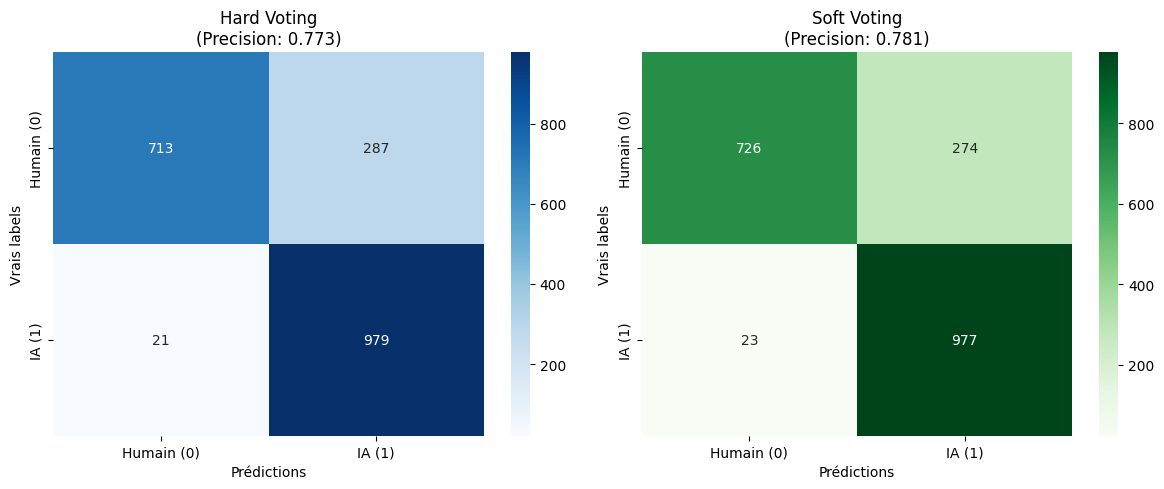


📊 Entraînement et évaluation de tous les modèles...

🔄 Cross-validation (5-fold) sur le dataset d'entraînement...
   (Mesure de la stabilité)

✓ Logistic Regression
   CV: Acc=0.723 | Prec=0.766 | Rec=0.831 | F1=0.783
   Test: Acc=0.764 | Prec=0.770 | Rec=0.752 | F1=0.761

✓ Random Forest
   CV: Acc=0.754 | Prec=0.871 | Rec=0.747 | F1=0.756
   Test: Acc=0.834 | Prec=0.752 | Rec=0.995 | F1=0.857

✓ XGBoost
   CV: Acc=0.780 | Prec=0.885 | Rec=0.781 | F1=0.790
   Test: Acc=0.852 | Prec=0.784 | Rec=0.971 | F1=0.867

✓ Hard Voting
   CV: Acc=0.776 | Prec=0.882 | Rec=0.776 | F1=0.785
   Test: Acc=0.846 | Prec=0.773 | Rec=0.979 | F1=0.864

✓ Soft Voting
   CV: Acc=0.780 | Prec=0.882 | Rec=0.783 | F1=0.792
   Test: Acc=0.852 | Prec=0.781 | Rec=0.977 | F1=0.868


📈 TABLEAU RÉCAPITULATIF COMPLET
              Model  CV Accuracy  CV Precision  CV Recall  CV F1  Test Accuracy  Test Precision  Test Recall  Test F1
            XGBoost        0.780         0.885      0.781  0.790          0.852     

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt

# === 1. Chargement des datasets ===
df_train = pd.read_csv("../datasets_source/features_ia_vs_humain_ml.csv")
df_test = pd.read_csv("../datasets_source/features_test_final.csv")

# Supprimer colonnes inutiles si présentes
for col in ["classe", "SYM"]:
    if col in df_train.columns:
        df_train = df_train.drop(columns=[col])
    if col in df_test.columns:
        df_test = df_test.drop(columns=[col])

# === 2. Séparation features / target ===
target = "label"
features = [col for col in df_train.columns if col != target]

X_train = df_train[features]
Y_train = df_train[target]

X_test = df_test[features]
Y_test = df_test[target]

# === 3. Prétraitement ===
# Imputation
imputer = SimpleImputer(strategy="median")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Standardisation
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# === 4. Définition des modèles optimisés ===
lr_best = LogisticRegression(
    C=45,
    max_iter=5000,
    penalty='l2',
    solver='lbfgs',
    random_state=42
)

rf_best = RandomForestClassifier(
    max_depth=None,
    max_features='sqrt',
    min_samples_leaf=1,
    n_estimators=300,
    random_state=42
)

xgb_best = XGBClassifier(
    gamma=0,
    learning_rate=0.3,
    max_depth=5,
    min_child_weight=1,
    n_estimators=300,
    subsample=1.0,
    random_state=42,
    eval_metric='logloss'
)

# === 5. Création des Voting Classifiers ===
voting_hard = VotingClassifier(
    estimators=[
        ('lr', lr_best),
        ('rf', rf_best),
        ('xgb', xgb_best)
    ],
    voting='hard'
)

voting_soft = VotingClassifier(
    estimators=[
        ('lr', lr_best),
        ('rf', rf_best),
        ('xgb', xgb_best)
    ],
    voting='soft'
)

# === 6. Entraînement ===
print("🚀 Entraînement des modèles...")
voting_hard.fit(X_train, Y_train)
voting_soft.fit(X_train, Y_train)
print("✅ Entraînement terminé !\n")

# === 7. Prédictions et métriques pour les 2 votings ===
y_pred_hard = voting_hard.predict(X_test)
y_pred_soft = voting_soft.predict(X_test)

# Métriques Hard Voting
acc_hard = accuracy_score(Y_test, y_pred_hard)
prec_hard = precision_score(Y_test, y_pred_hard)
rec_hard = recall_score(Y_test, y_pred_hard)
f1_hard = f1_score(Y_test, y_pred_hard)

# Métriques Soft Voting
acc_soft = accuracy_score(Y_test, y_pred_soft)
prec_soft = precision_score(Y_test, y_pred_soft)
rec_soft = recall_score(Y_test, y_pred_soft)
f1_soft = f1_score(Y_test, y_pred_soft)

# Tableau comparatif
results_voting = pd.DataFrame({
    "Voting Type": ["Hard Voting", "Soft Voting"],
    "Accuracy": [round(acc_hard, 3), round(acc_soft, 3)],
    "Precision": [round(prec_hard, 3), round(prec_soft, 3)],
    "Recall": [round(rec_hard, 3), round(rec_soft, 3)],
    "F1-score": [round(f1_hard, 3), round(f1_soft, 3)]
})

print("📊 Résultats sur le dataset de test :")
print(results_voting.to_string(index=False))
print()

# === 8. Matrices de confusion ===
cm_hard = confusion_matrix(Y_test, y_pred_hard)
cm_soft = confusion_matrix(Y_test, y_pred_soft)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Hard Voting
sns.heatmap(cm_hard, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=["Humain (0)", "IA (1)"],
            yticklabels=["Humain (0)", "IA (1)"])
axes[0].set_title(f"Hard Voting\n(Precision: {prec_hard:.3f})")
axes[0].set_xlabel("Prédictions")
axes[0].set_ylabel("Vrais labels")

# Soft Voting
sns.heatmap(cm_soft, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=["Humain (0)", "IA (1)"],
            yticklabels=["Humain (0)", "IA (1)"])
axes[1].set_title(f"Soft Voting\n(Precision: {prec_soft:.3f})")
axes[1].set_xlabel("Prédictions")
axes[1].set_ylabel("Vrais labels")

plt.tight_layout()
plt.show()

# === 9. Comparaison complète de tous les modèles ===
print("\n📊 Entraînement et évaluation de tous les modèles...")

# Entraîner les modèles individuels
lr_best.fit(X_train, Y_train)
rf_best.fit(X_train, Y_train)
xgb_best.fit(X_train, Y_train)

# Les voting classifiers sont déjà entraînés (section 6)

models = {
    "Logistic Regression": lr_best,
    "Random Forest": rf_best,
    "XGBoost": xgb_best,
    "Hard Voting": voting_hard,
    "Soft Voting": voting_soft
}

all_results = []

print("\n🔄 Cross-validation (5-fold) sur le dataset d'entraînement...")
print("   (Mesure de la stabilité)\n")

for name, model in models.items():
    # Cross-validation sur le train set
    scores_precision = cross_val_score(model, X_train, Y_train, cv=5, scoring='precision', n_jobs=-1)
    scores_accuracy = cross_val_score(model, X_train, Y_train, cv=5, scoring='accuracy', n_jobs=-1)
    scores_recall = cross_val_score(model, X_train, Y_train, cv=5, scoring='recall', n_jobs=-1)
    scores_f1 = cross_val_score(model, X_train, Y_train, cv=5, scoring='f1', n_jobs=-1)
    
    # Prédictions sur le test set
    y_pred = model.predict(X_test)
    
    acc_test = accuracy_score(Y_test, y_pred)
    prec_test = precision_score(Y_test, y_pred)
    rec_test = recall_score(Y_test, y_pred)
    f1_test = f1_score(Y_test, y_pred)
    
    all_results.append({
        "Model": name,
        "CV Accuracy": round(scores_accuracy.mean(), 3),
        "CV Precision": round(scores_precision.mean(), 3),
        "CV Recall": round(scores_recall.mean(), 3),
        "CV F1": round(scores_f1.mean(), 3),
        "Test Accuracy": round(acc_test, 3),
        "Test Precision": round(prec_test, 3),
        "Test Recall": round(rec_test, 3),
        "Test F1": round(f1_test, 3)
    })
    
    print(f"✓ {name}")
    print(f"   CV: Acc={scores_accuracy.mean():.3f} | Prec={scores_precision.mean():.3f} | Rec={scores_recall.mean():.3f} | F1={scores_f1.mean():.3f}")
    print(f"   Test: Acc={acc_test:.3f} | Prec={prec_test:.3f} | Rec={rec_test:.3f} | F1={f1_test:.3f}\n")

# DataFrame final
results_df = pd.DataFrame(all_results)
results_df = results_df.sort_values("Test Precision", ascending=False).reset_index(drop=True)

print("\n" + "="*100)
print("📈 TABLEAU RÉCAPITULATIF COMPLET")
print("="*100)
print(results_df.to_string(index=False))
print("="*100)